# Heterogenous Effect Mixture Model (HEMM) Demo

<img style="float:right;" src="https://i0.wp.com/makerfaire.com/wp-content/uploads/gravity_forms/145-c8d5744ce54ae5e6b8c251641327d92d/2017/04/ibmpos_black.jpg?fit=750%2C500&strip=all" width="20%"/>

# Contents

### 1. [Introduction](#Introduction) 
####    &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;  1.1 [Subgroup Discovery and Heterogenous Treatment Effect Problem](#introsgdisc)
####    &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;  1.2 [HEMM Description and Plate Notation](#introhemm)

       
### 2. [Synthetic Data Example](#syndata)


####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   2.1 [Data Description and Generative Process](#syndatagen)

####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   2.2 [Estimation of Counterfactual Outcomes, PEHE Estimation](#syndatapehe)

####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   2.3 [Subgroup Discovery](#syndatasg)

####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   2.4 [Bootstrapping PEHE Estimates](#syndatabs)


### 3. [IHDP Data Example](#IHDPdata)

####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   3.1 [Data Description](#IHDPdatadesc)

#### &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   3.1 Estimation of Counterfactual Outcomes, PEHE Estimation


<a id='Introduction'></a>
## 1. Introduction

In a large number of decision problems, estimating Heterogenous Outcomes to a treatment is not sufficient from a decision making perspective. A Neural Network might be able to approximate the Outcome and Corresponding Counterfactuals well, but deployment for real world decision making would be limited by lack of transparency and exaplinability of the Neural Model. 
The Heterogenous Effect Mixture Model approach was originally proposed in the paper
["***Interpretable Subgroup Discovery in Treatment Effect Estimation with Application to Opioid Prescribing Guidelines***"](https://arxiv.org/abs/1905.03297) in order to mitigate this challenge and allow decision makers more insight. 

<a id='introsgdisc'></a>
### 1.1 Subgroup Discovery and Heterogenous Treatment Effect Problem


The idea behind HEMM is involves assuming a low dimensional clustering or a latent $\mathcal{Z}$ for each individual in the dataset. An intuitive visual example of the following phenomenon is below in **Figure A**. Notice that, almost all instances receiving treatment in $\mathcal{Z}_1$ have a positive outcome, while very few in $\mathcal{Z}_3$ do. We are interested in recovering such latent subgroups. 
    

<table border="1">

<tr><td><center><img src="https://ndownloader.figshare.com/files/22805153" title="HEMM" width="90%"/></center><td><center><img src="https://ndownloader.figshare.com/files/22805156" title="HEMM"  width="60%"/></center></tr>
<tr><td><center><h3>Fig A. Example of the Heterogenous Effect Subgroup Problem</h3><center> <td><h3>Fig B. The HEMM Model in Plate Notation </h3></tr>
</table>

<a id='introhemm'></a>
### 1.2 HEMM Description and Plate Notation
    
In the HEMM model, this is carried out using a finite (${K}$) mixture of Normals and Bernoullis. The contribution of performing the Treatment is then mediated by belonging to one of the $K$ subgroups. 



<a id='syndata'></a>
## 2. Synthetic Data Example
This section will demonstrate **HEMM**'s ability on a synthetic dataset.

<a id='syndatagen'></a>

### 2.1 Data Description and Generative Process

We will use a Synthetic Dataset included with the **`HEMM`** module in **`causallib`** to demonstrate the ability of **HEMM** to discover subgroups, as well as hetereogenous effects. The synthetic dataset is generated according to the following scheme

<!---<img src="hemm_demo_resources/hemm_truedist.svg" title="HEMM" width="50%"/> --->

<img src="https://ndownloader.figshare.com/files/22805159" width="65%">


<center><h3> Fig C. The Generative Process for Synthetic Data </h3></center>


1. We take $
\mathbf{X} = (X_0, X_1) \in \mathbb{R}^2$ and sample it from a uniform distribution over $\mathcal{X} = [0,1]^2$. 

2. In order to simulate the selection bias inherent in observational studies, the treatment variable depends on $\mathbf{X}$ as $T \sim \text{Bernoulli}(0.4)$ for $x_0 < 0.5$ and $\text{Bernoulli}(0.6)$ for $x_0 > 0.5$.  

3. The potential outcomes $Y(0)$ and $Y(1)$ are also Bernoulli with means given by the functions of $\mathbf{X}$, $T$ shown in the figure.  The figure shows that $p(Y(1)=1 | \mathbf{X}) > p(Y(0)=1 | \mathbf{X})$, i.e. treatment increases the the treated population has a higher probability of positive outcome.  Note that under the conditional exchangeability assumption we have $p(Y(t)=1 | \mathbf{X}) = p(Y=1 | T=t, \mathbf{X})$.  

4. We model the effect of the confounders $\mathbf{X}$ by assigning higher probability to the upper triangular region of $\mathcal{X}$. This together with the distribution of $T$ imply that individuals who are more likely to have positive outcome regardless of treatment (upper triangle) are also more likely to receive treatment (right half-square). 

5. Lastly, we model the enhanced treatment effect group as a circular region $\mathcal{S} = \{x: \lVert x-c \rVert_{2} < r \}$, where $p(Y(1)=1 | \mathcal{S}) > p(Y(1)=1 | \mathcal{X}\backslash\mathcal{S})$. We set $c = ( \frac{1}{2}, \frac{1}{2})$ and $r = \frac{1}{4}$.  A total of $2,500$ samples $(\mathbf{x}_i, t_i, y_i)$ are generated as described above.



The `gen_montecarlo` from `causallib.contrib.hemm.gen_synthetic_data` allows us to randomly sample multiple instantiations of the synthetic dataset

In [1]:
from causallib.contrib.hemm.gen_synthetic_data import gen_montecarlo

syn_data = gen_montecarlo(5000, 2, 100)

<a id='syndatapehe'></a>

### 2.2 Estimation of Counterfactual Outcomes and PEHE Estimation

We will now fit an **HEMM** model to each realization of the Synthetic Dataset and evaluate the capability of **HEMM** to estimate the **ITE** ie. **Individual Treatment Effect**, also known as the **Conditional Average Treatment Effect** (**CATE**) using the **Precision of Estimating Heterogenous Effects Metric (PEHE)**. The **PEHE** is the Mean Squared Error around the ***ITE*** more formally defined as:

$$ \text{PEHE} = \frac{1}{n} \sum^{n}_{i=1}  \left(f_1(\mathbf{x_i}) - f_0(\mathbf{x}_i) - \mathbb{E}[Y(1) - Y(0)] | \mathbf{X} = \mathbf{x}_i] \right)^2.
$$
Here $f_0$ and $f_1$ represent the functions used to estimate the counterfactual outcome for an observation with features $\mathbf{x_i}$. The Second term inside the parenthesis is the **True CATE**. Note that the **True CATE** can only be observed in synthetic settings and not real world observational data and hence using **PEHE** as a metric ofestimating goodness of fit for **CATE** is limited to synthetic datasets.

In [2]:
from causallib.contrib.hemm import HEMM

In [3]:
#Leave 30% of the Training Data as Validation
vsize = int(0.3*syn_data['TRAIN']['x'].shape[0])

In [4]:
#setting the Training Dataset
Xtr  = syn_data['TRAIN']['x'] [:-vsize,:, 0]
Ytr  = syn_data['TRAIN']['yf'][:-vsize  , 0]
Ttr  = syn_data['TRAIN']['t'] [:-vsize  , 0]

#setting the Dev/Val Dataset
Xdev = syn_data['TRAIN']['x'] [-vsize:,:, 0]
Ydev = syn_data['TRAIN']['yf'][-vsize:  , 0]
Tdev = syn_data['TRAIN']['t'] [-vsize:  , 0]

#setting the Test Dataset
Xte  = syn_data['TEST']['x'] [:,:, 0]
Yte  = syn_data['TEST']['yf'][:  , 0]
Tte  = syn_data['TEST']['t'] [:  , 0]

#Feature size
Xdim = Xtr.shape[1]

#Number of Components to Discover.
K = 3

#Initialize the model with Population means and Std. Devs.
#Empirically results in faster, and better convergence.
mu  = Xtr.mean(axis=0).reshape(1,-1)
std = Xtr.std(axis=0).reshape(1,-1)

#Set the Learning Rate for Adam Optimizer and Batch Size
learning_rate = 1e-4
batch_size    = 100

#Indicate the Outcome Distribution (Y), could be 'bin' for 
#Binary Outcomes or 'cont' for Continuous Outcomes.
response = 'bin'

#Indicate what kind of a model to be used to adjust for 
#confounding. You can also pass your own PyTorch Model!!!!
outcome_model='linear'

#Instantiate an HEMM model
model = HEMM(Xdim, K, homo=True, mu=mu, std=std, bc=2, lamb=0.0000,\
                spread=.1,outcome_model=outcome_model,sep_heads=True,epochs=10,\
                 learning_rate=learning_rate,weight_decay=0.0001,metric='LL', use_p_correction=False,\
                 response=response,imb_fun=None,batch_size=batch_size )


#Fit the HEMM model on the Training Data, with Early Stopping
#on the Dev Set.
cd = model.fit(Xtr, Ttr,Ytr, validation_data=(Xdev, Tdev, Ydev))


In [5]:
#Extract the True Potential outcomes for the Training 
#and the Test Dataset.
mu1tr = syn_data['TRAIN']['mu1'][:-vsize, 0] 
mu0tr = syn_data['TRAIN']['mu0'][:-vsize, 0]

mu1te = syn_data['TEST']['mu1'][:, 0] 
mu0te = syn_data['TEST']['mu0'][:, 0]

In [6]:
#Estimate the Individual Potential Outcomes using HEMM
inSampleCFoutcomes  = model.estimate_individual_outcome(Xtr, Ttr)
outSampleCFoutcomes = model.estimate_individual_outcome(Xte, Tte)

In [7]:
#Compute the True In-sample Individual Treatment Effect (ITE)
trueCATE = mu1tr - mu0tr

#Compute the In-Sample  ITEs
inSampleITE = inSampleCFoutcomes[1]-inSampleCFoutcomes[0]

#Compute the In-Sample PEHE
inSamplePEHE = ((inSampleITE - trueCATE)**2).mean()
print("In Sample PEHE:", inSamplePEHE)



In Sample PEHE: 0.011010778786300154


In [8]:
#Compute the True Out of Sample Individual Treatment Effect (ITE)
trueCATE = mu1te - mu0te

#Compute the Out of Sample  ITEs
outSampleITE = outSampleCFoutcomes[1]-outSampleCFoutcomes[0]

#Compute the Out of Sample PEHE
outSamplePEHE = ((outSampleITE - trueCATE)**2).mean()

print("In Sample PEHE:", outSamplePEHE)

In Sample PEHE: 0.010915930183215048


As you can see, **HEMM** returns a **low PEHE** score, justifying its ability to estimate Heterogenous Effects to Treatment.

<a id='syndatasg'></a>
### 2.3  Subgroup Discovery

We will now demonstrate **HEMM**'s ability to extract the Subgroup with the **Enhanced Treatment Effect**. We will first use the `get_groups_effect` member function of the **`HEMM`** class to extract the absolute values of the Treatment Effect Terms ( **$\gamma_k$** in Figure B )

In [9]:
import numpy as np

gamma = model.get_groups_effect()
print(gamma)

K = np.argmax(gamma) 

print ("Subgroup", K+1, "demonstrates a Higher Effect to Treatment")



[0.69842033 0.71704322 0.50003658]
Subgroup 2 demonstrates a Higher Effect to Treatment


Now that we have identified the Subgroup with Higher Effect to Treatment, we will compute the ability of **HEMM** to extract the subgroup by comparing with the True Subgroup Assignment

In [10]:
ZinSample  = model.get_groups_proba(Xtr)
ZoutSample = model.get_groups_proba(Xte)

Now that we have the group assignment scores, we will compute the ROC Curve and Precision-Recall Statistic in Recovering the Subgroups

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve

trueInSampleZ  = syn_data['TRAIN']['z'][:-vsize, 0] 
trueOutSampleZ = syn_data['TEST']['z'][:,0] 

inSample_roc_auc  = roc_auc_score( trueInSampleZ , ZinSample[K] )
outSample_roc_auc = roc_auc_score( trueOutSampleZ, ZoutSample[K])

print ("In Sample ROC AUC:", inSample_roc_auc)
print ("Out Sample ROC AUC:", outSample_roc_auc)


In Sample ROC AUC: 0.9738558368695354
Out Sample ROC AUC: 0.9772955843564394


Let us now Plot the ROC Curves

In [1]:
infpr , intpr , _ = roc_curve( trueInSampleZ  , ZinSample[K] )
outfpr, outtpr, _ = roc_curve( trueOutSampleZ , ZoutSample[K] )

from matplotlib import pyplot as plt
plt.title("ROC Curve")
plt.plot(infpr , intpr, label = "In-Sample")
plt.plot(outfpr, outtpr, label= "Out-Sample")
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),c='k', label='Random', ls=':')
plt.xscale('linear')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()


NameError: name 'roc_curve' is not defined

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score


inSample_pr_auc  = average_precision_score( trueInSampleZ , ZinSample[K] )
outSample_pr_auc = average_precision_score( trueOutSampleZ, ZoutSample[K])

print ("In Sample  PR AUC:", inSample_pr_auc)
print ("Out Sample PR AUC:", outSample_pr_auc)


In Sample  PR AUC: 0.9486824676876224
Out Sample PR AUC: 0.9545712084631546


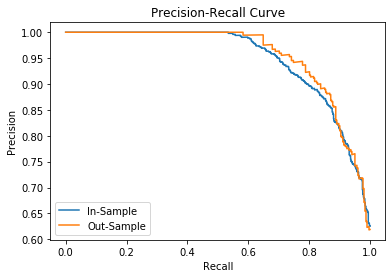

In [28]:
inpr , inre , _ = precision_recall_curve( trueInSampleZ  , ZinSample[K] )
outpr, outre, _ = precision_recall_curve( trueOutSampleZ , ZoutSample[K] )

from matplotlib import pyplot as plt
plt.title("Precision-Recall Curve")
plt.plot(inre , inpr, label = "In-Sample")
plt.plot(outre, outpr, label= "Out-Sample")
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


### 2.4 Qualitative Assesment of the Discovered Subgroups
In the previous section, we attempted to perform some Quantitative assesment of the capability of **HEMM** to discover the subgroups with **Enhanced Treatment Effects**. Since we had access to the **True Subgroup Assignment Label**, we proceeded to compute the **ROC** and **Precision-Recall** characteristic. In this section, we will attempt to perform a more qualitative assessement by plotting the Subgroups with a heatmap.

In [29]:
#Let's first create a uniform grid over the feature space. 

d = 100

x1 = np.linspace(0, 1, d)
x2 = np.linspace(0, 1, d)

Xgrid = np.meshgrid(x1, x2)

Xgrid[0] = Xgrid[0].reshape(-1,1)
Xgrid[1] = Xgrid[1].reshape(-1,1)

Xgrid = np.hstack([Xgrid[0], Xgrid[1], np.ones_like(Xgrid[1])])

Zgrid = model.get_groups_proba(Xgrid)[K].values

Zgrid = Zgrid.reshape(d, d)

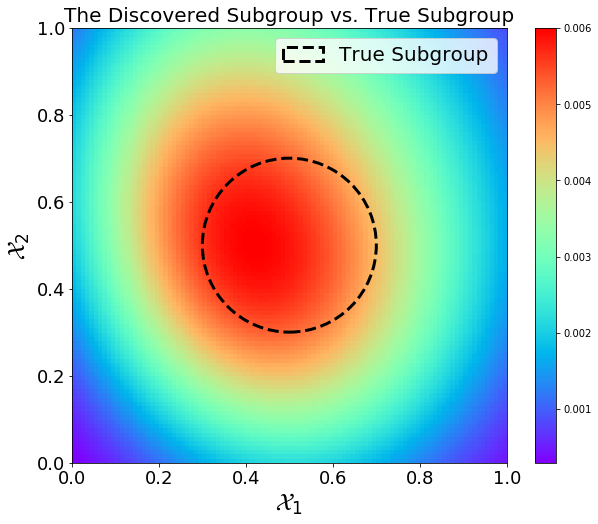

Notice how HEMM comes close to recover the True Subgroup


In [30]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,8))

axis = plt.gca()

plt.imshow(Zgrid**5, cmap='rainbow', interpolation='nearest', origin='lower', extent=[0, 1, 0, 1])

truesg = plt.Circle((0.5, 0.5), 0.2, color='k', lw='3', ls='--', fc='none', label='True Subgroup')
plt.gca().add_artist(truesg)
plt.legend(handles=[truesg], fontsize=20)
plt.xlabel(r'$\mathcal{X}_1$', size=24)
plt.ylabel(r'$\mathcal{X}_2$', size=24)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title("The Discovered Subgroup vs. True Subgroup", size=20)
plt.colorbar(orientation='vertical')
plt.show()

print  ("Notice how HEMM comes close to recover the True Subgroup")

<a id='syndatabs'></a>
### 2.5 Bootstrapping PEHE Estimates

Till now we have only looked at Point Estimates for the Counterfactual Outcomes and the Associated **PEHE** score. For fair comparison we would also like to estimate the uncertainity around our estimates of **PEHE** by computing a **Bootstrapped Confidence Interval**. We will compute this by fitting multiple models on each bootstrapped realization of the Synthetic Dataset. 

We will wrap the previous experiment into a single function, and use `joblib` to parallelly estimate the **PEHE** in each bootstrapped realization.

In [23]:
###################################################################################
# NOTE: For more complicated decision problems, linear adjustment for confounding #
# may not be sufficient. HEMM allows passing any PyTorch model for determining    #
# the outcome as a function of the features independent of the Treatment          # 
# assignment. The parameters of this 'Outcome Model' and the underlying,          #
# 'Heterogenous Effect Mixture Model' are optimized jointly. HEMM implementation  #
# in Causllib, has helper functions to instantiate Neural Network outcome models. # 
###################################################################################

from causallib.contrib.hemm.outcome_models import genMLPModule, genLinearModule, BalancedNet


def experiment(data, i, K=2, response='bin', outcomeModel='linear', lr=1e-3, batch_size=100, vsize=0.3, bc=2, epochs=20):
    
    vsize = int(vsize*data['TRAIN']['x'].shape[0])
    
    Xtr  = data['TRAIN']['x'] [:-vsize,:, i]
    Ytr  = data['TRAIN']['yf'][:-vsize  , i]
    Ttr  = data['TRAIN']['t'] [:-vsize  , i]

    Xdev = data['TRAIN']['x'] [-vsize:,:, i]
    Ydev = data['TRAIN']['yf'][-vsize:  , i]
    Tdev = data['TRAIN']['t'] [-vsize:  , i]

    Xte  = data['TEST']['x'] [:,:, i]
    Yte  = data['TEST']['yf'][:  , i]
    Tte  = data['TEST']['t'] [:  , i]
    
    mu1tr = data['TRAIN']['mu1'][:-vsize, i] 
    mu0tr = data['TRAIN']['mu0'][:-vsize, i]

    mu1te = data['TEST']['mu1'][:, i] 
    mu0te = data['TEST']['mu0'][:, i]

    mu  = Xtr.mean(axis=0).reshape(1,-1)
    std = Xtr.std(axis=0).reshape(1,-1)
        

    #Set the preferred Outcome Adjustment
    if outcomeModel == 'MLP':
        outcomeModel = genMLPModule(Xte.shape[1], Xte.shape[1], 2 )
    elif outcomeModel == 'linear':
        outcomeModel = genLinearModule(Xte.shape[1], 2 )
    elif outcomeModel == 'CF':
        outcomeModel = BalancedNet(Xte.shape[1], Xte.shape[1], 1 )
        
    Xdim = Xte.shape[1]
        
    model = HEMM(Xdim, K, homo=True, mu=mu, std=std, bc=bc, lamb=0.0000,\
                spread=.01,outcome_model=outcome_model,sep_heads=True,epochs=epochs,\
                 learning_rate=learning_rate,weight_decay=0.0001,metric='LL', use_p_correction=False,\
                 response=response,imb_fun=None,batch_size=batch_size )

    

    cd = model.fit(Xtr, Ttr,Ytr, validation_data=(Xdev, Tdev, Ydev))
    
    inSampleCFoutcomes  = model.estimate_individual_outcome(Xtr, Ttr)
    outSampleCFoutcomes = model.estimate_individual_outcome(Xte, Tte)
    
    inSampleITE = inSampleCFoutcomes[1]-inSampleCFoutcomes[0]
    outSampleITE = outSampleCFoutcomes[1]-outSampleCFoutcomes[0]

    #Compute the In-Sample PEHE
    trueCATE = mu1tr - mu0tr
    inSamplePEHE = np.sqrt(((inSampleITE - trueCATE)**2).mean())

    #Compute the Out of Sample PEHE
    trueCATE = mu1te - mu0te
    outSamplePEHE = np.sqrt(((outSampleITE - trueCATE)**2).mean())


    return [inSamplePEHE, outSamplePEHE]

In [24]:
from joblib import Parallel, delayed

PEHEs = Parallel(n_jobs=10)(delayed(experiment)(data=syn_data, i=i, K=3,lr=1e-4) for i in range(100))

In [25]:
PEHEmean =  np.mean(PEHEs,axis=0)

PEHEstd =  np.std(PEHEs,axis=0)

print ("In  Sample Root PEHE", PEHEmean[0], ',', "Std. Error", PEHEstd[0]/np.sqrt(100) )
print ("Out Sample Root PEHE", PEHEmean[1],',', "Std. Error", PEHEstd[1]/np.sqrt(100) )

In  Sample Root PEHE 0.10267147617234845 , Std. Error 0.0001256753369609759
Out Sample Root PEHE 0.1026503798822282 , Std. Error 0.0001542102418122442


In [708]:
#syn_data

<a id='IHDPdata'></a>
## 3. IHDP Example
In this section, we will experiment with the IHDP dataset. As opposed to the previous dataset the IHDP dataset comes from a real world study, with simulated outcomes and hence is considered 'Semi-Synthetc'.


<a id='IHDPdatadesc'></a>
### 3.1 Data Description

The **UN Infant Health Development Program** (**IHDP**) dataset has gained popularity in the causal inference literature dealing with heterogenous treatment effects. The original data includes 25 real covariates and comes from a randomized experiment to evaluate the benefit of **IHDP** on IQ scores of three-year-old children. A selection bias was introduced by removing some of the treated population, thus resulting in **608 control** patients and **139 treated** (**747 total**). The outcomes were simulated using the standard non-linear **‘Response Surface B’** as described in 
***Hill, J. L. (2011). Bayesian nonparametric modeling for causal inference. Journal of Computational and Graphical Statistics, 20(1), 217-240.***


**`causallib`**'s **`HEMM`** module contains helper functions to download the **IHDP** dataset courtesy of _Frederik Johansson's_ [Personal Website](https://www.fredjo.com) 

In [34]:
from causallib.contrib.hemm.load_ihdp_data import loadIHDPData

ihdp_data = loadIHDPData()


IHDP Data exists


In [32]:
from joblib import Parallel, delayed

PEHEs = Parallel(n_jobs=10)(delayed(experiment)(data=ihdp_data, i=i,outcomeModel='CF', K=3,lr=1e-3,vsize=0.25, batch_size=10, bc=6, response='cont', epochs=500) for i in range(10))

In [33]:
PEHEmean =  np.mean(PEHEs,axis=0)

PEHEstd =  np.std(PEHEs,axis=0)

print ("In  Sample Root PEHE", PEHEmean[0], ',', "Std. Error", PEHEstd[0]/np.sqrt(100) )
print ("Out Sample Root PEHE", PEHEmean[1],',', "Std. Error", PEHEstd[1]/np.sqrt(100) )

In  Sample Root PEHE 4.779168419249578 , Std. Error 0.8265074053983431
Out Sample Root PEHE 4.300757764814082 , Std. Error 0.7104830767106435
